<a href="https://colab.research.google.com/github/ayush12gupta/Probabilistic-ML-ACA-/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.stats import norm
import random

**Initialisation**

In [0]:
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)

In [0]:
class VAE(nn.Module):
    def __init__(self):
      super(VAE,self).__init__()
      dim=2
      n=
      self.enco_conv=nn.Sequential(nn.Conv2d(1,32,kernel_size=4,stride=2,padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU())
                                  
      self.mu=nn.Linear(128*7*7,dim)
      self.logvar=nn.Linear(128*7*7,dim)
      self.fc=nn.Linear(dim,128*7*7)
      self.decode=nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(64,32,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(32),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(32,1,kernel_size=4,stride=2,padding=1),
                                 nn.Sigmoid())
    
    def encoder(self, x):
        out=self.enco_conv(x)
        return self.mu(out.view(out.size(0) ,-1)), self.logvar(out.view(out.size(0) ,-1))

    def sampler(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())  
        esp = Variable(esp)
        esp=esp.cuda()
        z = esp.mul(std).add_(mu)
        return z     

    def decoder(self, x):  #x:100x2
        out=self.fc(x)
        out=self.decode(out.view(x.size(0),128,7,7))
        return out
        
    def forward(self, x):
        mu, logvar=self.encoder(x)
        #print(mu.shape)
        out=self.sampler(mu,logvar)
        #print(out.shape)
        out=self.decoder(out)
        return mu, logvar, out


In [64]:
if torch.cuda.is_available():
  print("!")

!


**Model**

**Loss Calculation**

In [0]:
vae=VAE()
vae.cuda()
loss_function = nn.BCELoss()
optimizer = optim.Adam(vae.parameters(), lr=0.001)
def loss_fn(x_in,x_out,mu,logvar):
    BCE = F.binary_cross_entropy(x_out,x_in, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = KLD+BCE/100
    return loss

**Train model**

In [0]:
def train(model,optimizer,num_iter=50):
    losses=[]
    iter_loss=[]
    model.train()
    for epoch in range(num_iter):
        iter_loss=[]

        for idx, (image,_) in enumerate(trainset):

            x=Variable(image)
            model.zero_grad()
            x=x.cuda()
            mu, logvar, x_out = model.forward(x)
            loss = loss_fn(x,x_out,mu,logvar)
            loss.backward()
            optimizer.step()
            losses.append(format(loss))

            iter_loss.append(format(loss))  
            if idx % 100 == 0 : 
                print("loss = {} epoch = {} minibatch = {}".format(sum([float(x) for x in iter_loss])/(idx+1),epoch,idx/100))
        iter_loss.append(sum([float(x) for x in iter_loss])/600)
        print("Epoch {} completed . Epoch loss = {}".format(epoch+1,sum([float(x) for x in iter_loss])/(600)))


    return loss,iter_loss

In [0]:
print(iter_loss)


['141.1386260986328', '133.03253173828125', '145.18344116210938', '140.96044921875', '142.28147888183594', '130.48379516601562', '134.9349822998047', '149.21742248535156', '140.06161499023438', '146.7195587158203', '142.18553161621094', '148.46820068359375', '139.27867126464844', '137.4502716064453', '135.7757568359375', '131.9813995361328', '137.862548828125', '148.52784729003906', '135.3114471435547', '139.65467834472656', '135.31869506835938', '143.55593872070312', '140.98379516601562', '143.5625762939453', '139.58938598632812', '144.4972381591797', '136.06199645996094', '144.98109436035156', '147.55279541015625', '137.2412872314453', '142.7664337158203', '142.7581787109375', '136.89315795898438', '143.0532989501953', '138.99082946777344', '148.36260986328125', '140.7975311279297', '136.88949584960938', '148.25424194335938', '133.58595275878906', '144.2838897705078', '140.58197021484375', '133.49574279785156', '140.9252471923828', '147.11911010742188', '146.34661865234375', '137.967

In [67]:
train_loss,iter_loss = train(vae,optimizer)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss = 584.4572143554688 epoch = 0 minibatch = 0.0
loss = 229.18372700001933 epoch = 0 minibatch = 1.0
loss = 203.5593449986396 epoch = 0 minibatch = 2.0
loss = 192.31258486117238 epoch = 0 minibatch = 3.0
loss = 185.3130093239192 epoch = 0 minibatch = 4.0
loss = 180.72416449449733 epoch = 0 minibatch = 5.0
Epoch 1 completed . Epoch loss = 177.82455126258
loss = 159.5867462158203 epoch = 1 minibatch = 0.0
loss = 158.44258616230275 epoch = 1 minibatch = 1.0
loss = 157.98354092877895 epoch = 1 minibatch = 2.0
loss = 157.54131152384304 epoch = 1 minibatch = 3.0
loss = 157.31780480743942 epoch = 1 minibatch = 4.0
loss = 157.1102588219557 epoch = 1 minibatch = 5.0
Epoch 2 completed . Epoch loss = 157.0489166874356
loss = 149.4501495361328 epoch = 2 minibatch = 0.0
loss = 154.1473435505782 epoch = 2 minibatch = 1.0
loss = 153.54884247281657 epoch = 2 minibatch = 2.0
loss = 153.41622488839286 epoch = 2 minibatch = 3.0
loss = 152.96955308414755 epoch = 2 minibatch = 4.0
loss = 152.791273440667

**Original Image**

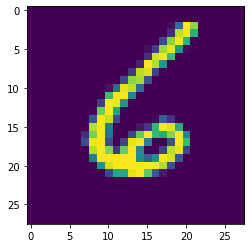

In [73]:
with torch.no_grad():
    for data in testset:
        X, y = data
        #X=X.cuda()
        #print(X.shape)
        #output = vae(X.view(-1,784))

#print(X.shape,y)
plt.imshow(X[8].view(28,28))
plt.savefig('original')
plt.show()


**Image obtained from Decoder**

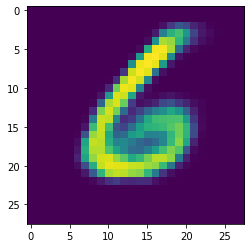

In [74]:
#print(X[0].shape)
X=X.cuda()
vae.cuda()

mu,logvar,out= vae.forward(X[8].view(1,1,28,28))
out = out.view(28,28)
out = out.cpu()
out = out.detach().numpy()
#print(out[0])
plt.imshow(out)
plt.savefig('decode')
plt.show()


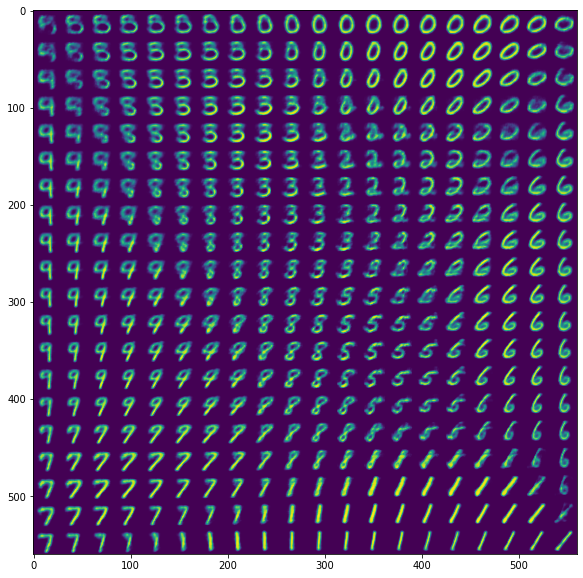

In [70]:
def visualise(model, num):
    grid = np.zeros([28*num,28*num])
    space = norm.ppf(np.linspace(0.01,0.99,num))
    #print(space)
    for i,a in enumerate(space):
        for j,b in enumerate(space):
            out = torch.FloatTensor([[a,b]])
            out=out.cuda()
            #print(out.size(0))
            img=vae.decoder(out)
            img=img.cpu()
            img=img.detach().numpy()
            grid[(i*28):((i+1)*28),(j*28):((j+1)*28)]=img

    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.savefig(fname='mainfold')
    plt.show()        

visualise(vae,20)